# Topics in Deep Learning : Non-negative Matrix Factorization

### Vansh Tandon


# Iterative NMF

### In this approach we will be looking at how iterative Non-negative Matrix Factorization works. We have a dataset of faces, with multiple photos of 40 people. We first split our data into training and testing data, then we apply iterative NMF on it. Iterative NMF includes initializing W and H randommly, then iteratively updating W and H until they converge below the threshold or we reach a satisfactory number of iterations. Then we visualise the Features and Codes, and then reconstruct the images based on the converged W and H. These reconstucted images are then compared to the original images. Then we use a simple K-Nearest Neighbors algorithm to classify the testing data into the 40 labels.    

In [15]:
# importing required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [16]:
# Loading the Olivetti Faces dataset and splitting it into training and validation sets
X, y = fetch_olivetti_faces(return_X_y=True)
X = X.T
X_train, X_val, y_train, y_val = train_test_split(X.T, y, test_size=0.2, random_state=42)

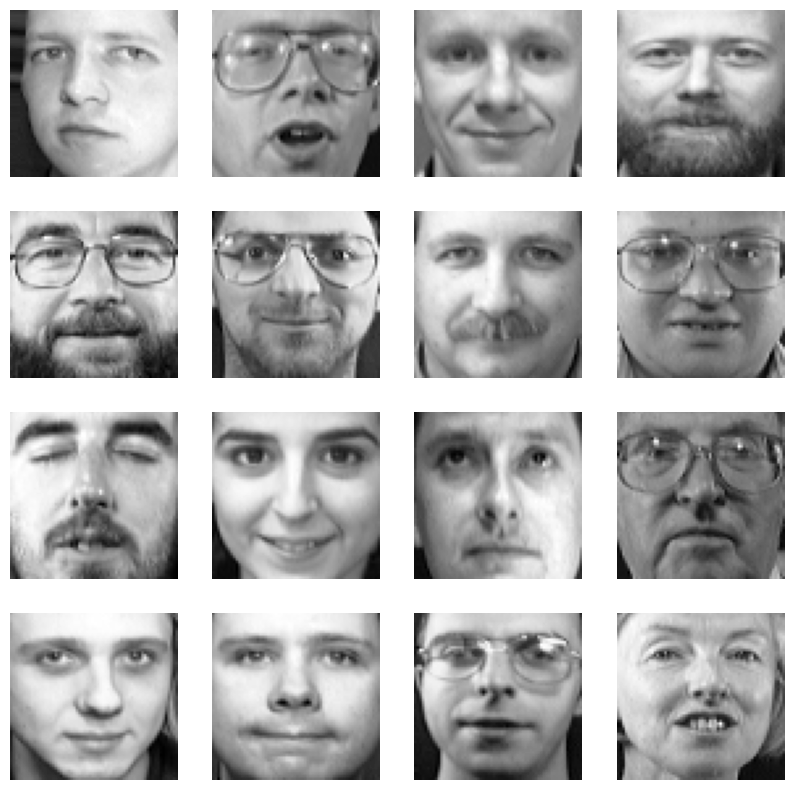

In [17]:
# print images from the training set
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_train[i].reshape(64, 64), cmap="gray")
    plt.axis("off")

In [18]:
def frobenius_norm(X, Y):
    return torch.sqrt(torch.sum((X - Y)**2))

In [20]:
def iterative_nmf(A, r,  max_iter=1000, tol=1e-7):
    p, n = A.shape
    # initializing W and H
    W = np.random.rand(p, r)
    H = np.random.rand(r, n)

    # iterate
    for i in range(max_iter):
        W = W * (A @ H.T) / (W @ H @ H.T)
        H = H * (W.T @ A) / (W.T @ W @ H)
        if i%100==0 or i==max_iter-1:
            print("Iteration: ", i, " loss : ", frobenius_norm(
                torch.Tensor(A), torch.Tensor(W @ H)))
        if frobenius_norm(
                torch.Tensor(A), torch.Tensor(W @ H)) < tol:
            break
    return H, W

In [5]:
W , H = iterative_nmf(X_train, 121, max_iter=1000, tol=1e-7)

Iteration:  0  loss :  tensor(141.4305)
Iteration:  100  loss :  tensor(79.1607)
Iteration:  200  loss :  tensor(61.7192)
Iteration:  300  loss :  tensor(55.0436)
Iteration:  400  loss :  tensor(51.5277)
Iteration:  500  loss :  tensor(49.3679)
Iteration:  600  loss :  tensor(47.9184)
Iteration:  700  loss :  tensor(46.8862)
Iteration:  800  loss :  tensor(46.1194)
Iteration:  900  loss :  tensor(45.5291)


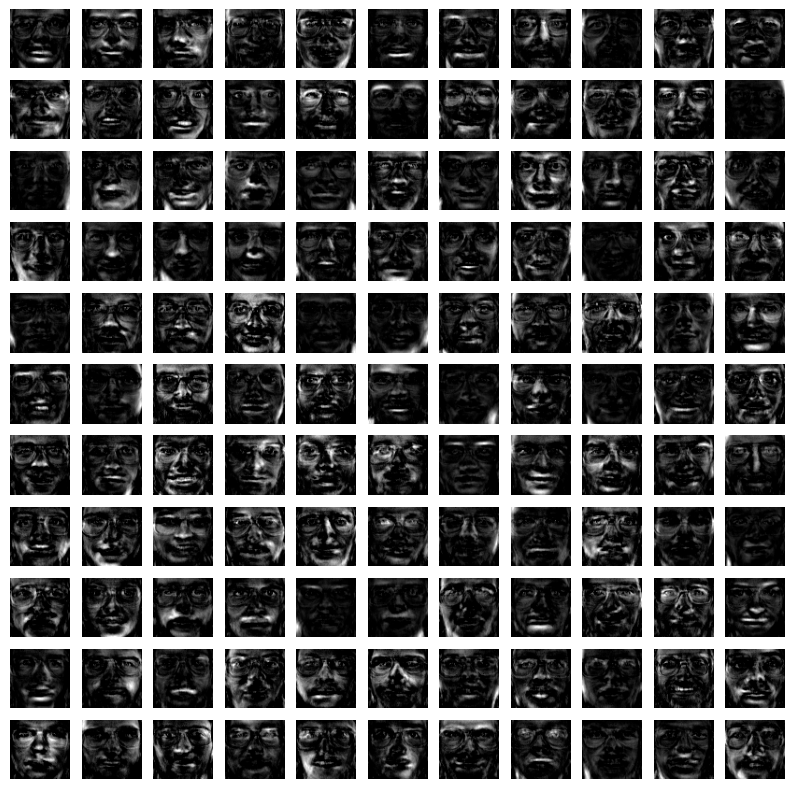

In [21]:
# plot of the W matrix
fig , ax = plt.subplots(11, 11, figsize=(10, 10))
for i in range(11):
    for j in range(11):
        ax[i, j].imshow(W.T[:, i*11+j].reshape(64, 64), cmap="gray")
        ax[i, j].axis("off")
        

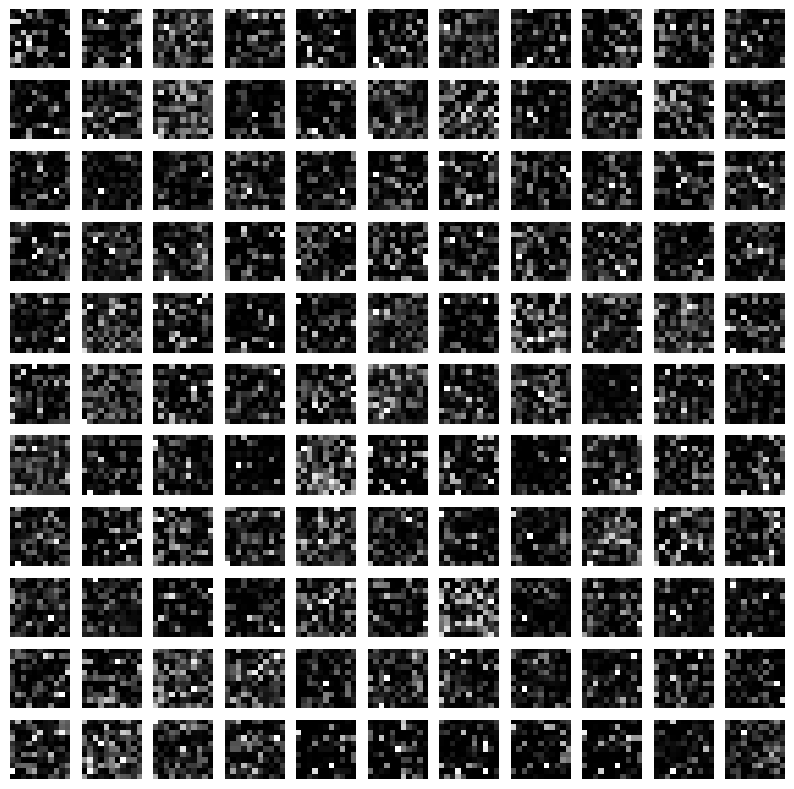

In [22]:
# plot of the H matrix
fig , ax = plt.subplots(11, 11, figsize=(10, 10))
for i in range(11):
    for j in range(11):
        ax[i, j].imshow(H.T[:, i*11+j].reshape(11, 11), cmap="gray")
        ax[i, j].axis("off")
        

#### Comparing the reconstructions to the original images 

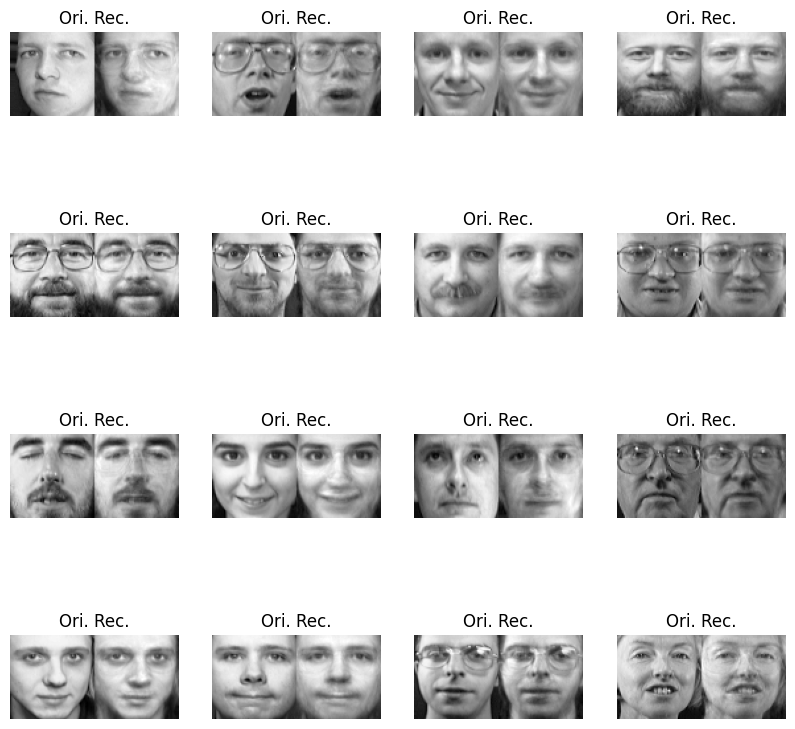

In [23]:
# reconstructing and plotting the original and reconstructed images side-by-side
fig , ax = plt.subplots(4, 4, figsize=(10, 10))
x_reconstructed = H@W
for i , axi in enumerate(ax.flat):
    axi.imshow(np.hstack((X_train[i].reshape(64, 64), x_reconstructed[i].reshape(64, 64))), cmap="gray")
    axi.axis("off")
    axi.set_title("Ori. Rec.")

#### Applying KNN Classifier with K = 1,3,5

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [12]:
'''
X = W . H
H = X . H_inv
'''

W_inv = np.linalg.pinv(W)
W_inv.shape, X_val.shape

((4096, 121), (80, 4096))

In [14]:
for i in [1,3,5]:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(H, y_train)
    H_ = X_val @ W_inv
    y_pred = knn.predict(H_)
    print("Accuracy for k = ", i, " : ", accuracy_score(y_val, y_pred))

Accuracy for k =  1  :  0.925
Accuracy for k =  3  :  0.85
Accuracy for k =  5  :  0.8125


## By trial we find that 'K' as 1 gives the best results by far with 'r' value set to 121 iterating 1000 times. We end up with an accuracy of 92.5% using this method.  

##

## Deep NMF

## We use a 2 layered neural network to decompose the matrix. The computation is done on the GPU for efficiency, Relu is used for implementing non-negativity, and frobineus norm for the loss function.

In [4]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((320, 4096), (320,), (80, 4096), (80,))

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# nn.Module class to implement the NMF neural network
class NMFNet(nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.l1 = nn.Linear(4096, 1024)
        self.l2 = nn.Linear(1024, n_components)
        self.relu = nn.ReLU()
        
        self.W = None
        self.H = None
    
    def forward(self, x):
        self.H = self.relu(self.l1(x))
        self.H = self.relu(self.l2(self.H))
        self.W = (self.l2.weight@self.l1.weight).clamp(min=0)
        return self.H @ self.W


criterion = frobenius_norm

# optim.Adam optimizer to update the weights of the neural network during training
learning_rate = 0.001
nmf_net = NMFNet(n_components=121)
optimizer = optim.Adam(nmf_net.parameters(), lr=learning_rate)

In [27]:
X_val = torch.Tensor(X_val)

In [8]:
losses = []
epochs = 1000

In [9]:
nmf_net.to(device)

NMFNet(
  (l1): Linear(in_features=4096, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=121, bias=True)
  (relu): ReLU()
)

In [10]:
# Train the neural network on the training set using the GPU
for i in tqdm(range(epochs)):
    optimizer.zero_grad()
    predictions = nmf_net(torch.tensor(X_train).to(device).float())
    loss = frobenius_norm(predictions, torch.tensor(X_train).to(device).float())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:23<00:00, 43.27it/s]


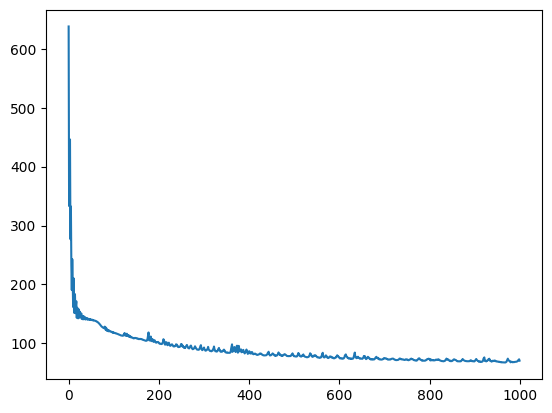

In [11]:
plt.plot(losses);

### Evaluation on validation data

In [25]:
# Evaluating the performance of the neural network on the validation set
with torch.no_grad():
    nmf_net.eval()
    total_loss = 0
    outputs = nmf_net(torch.tensor(X_val).to(device).float())
    total_loss += frobenius_norm(outputs, torch.tensor(X_val).to(device).float()).item()
    avg_loss = total_loss / len(X_val)
    print('Validation Loss: {:.4f}'.format(avg_loss))

Validation Loss: 0.4724


C:\Users\Asus\AppData\Local\Temp\ipykernel_27116\232212403.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = nmf_net(torch.tensor(data).to(device).float())


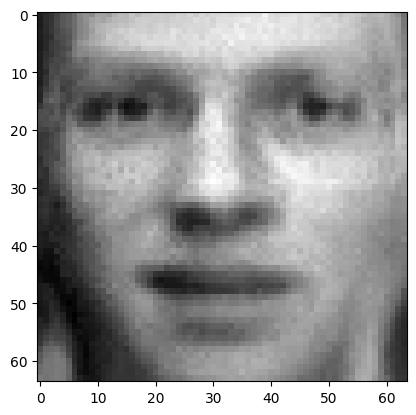

In [34]:
# Generating the reconstructed images from the neural network
with torch.no_grad():
    nmf_net.eval()
    data = next(iter(X_val))
    outputs = nmf_net(torch.tensor(data).to(device).float())
    outputs = outputs.cpu().numpy()
    outputs = outputs.reshape(64, 64)
    plt.imshow(outputs, cmap="gray")    
    

### Visualization of W matrix

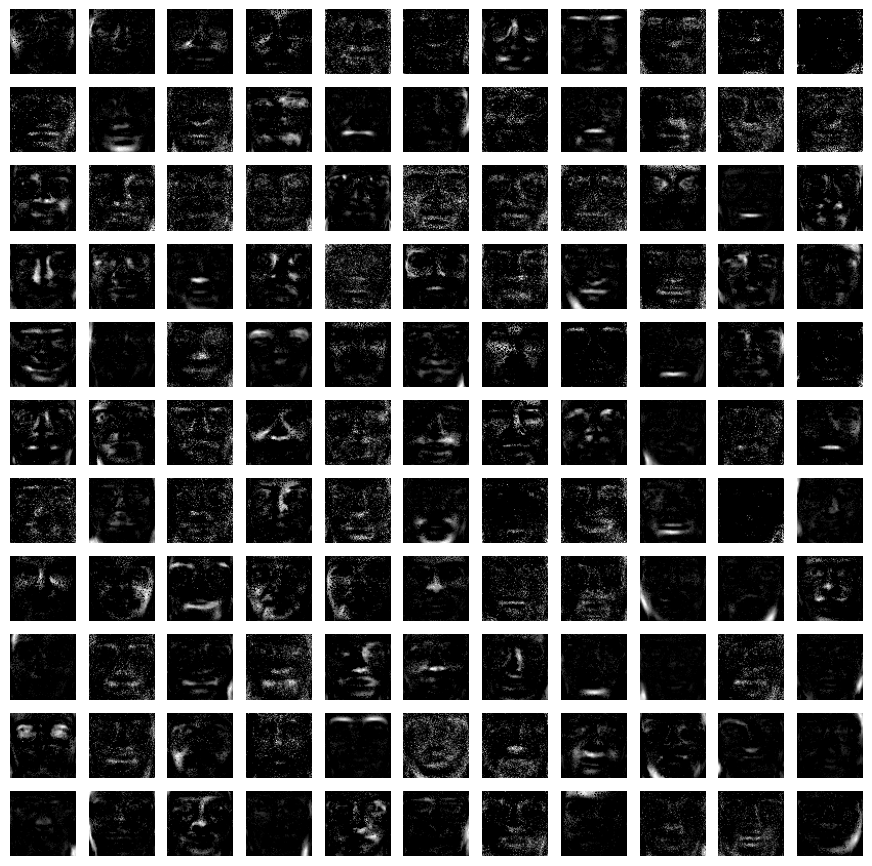

In [29]:
plt.figure(figsize=(11, 11))
for i in range(121):
    plt.subplot(11, 11, i+1)
    plt.imshow(nmf_net.W[i].cpu().detach().numpy().reshape(64, 64), cmap="gray")
    plt.axis("off")

### Visualization of Original vs Reconstructed Images

C:\Users\Asus\AppData\Local\Temp\ipykernel_27116\359950644.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = nmf_net(torch.tensor(X_val).to(device).float())


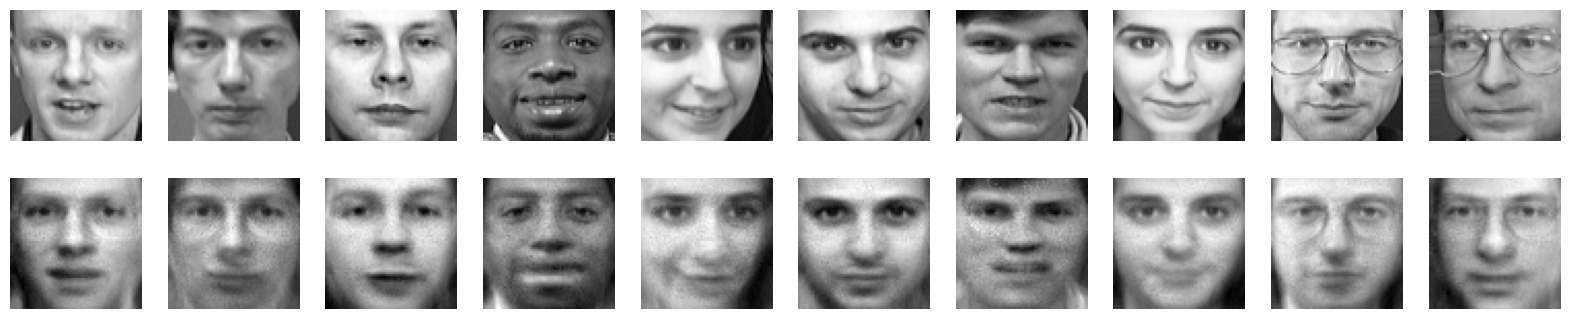

In [35]:
with torch.no_grad():
    nmf_net.eval()
    outputs = nmf_net(torch.tensor(X_val).to(device).float())
    outputs = outputs.cpu().numpy()
    outputs = outputs.reshape(-1, 64, 64)
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    ax[0, i].imshow(X_val[i].cpu().numpy().reshape(64, 64), cmap="gray")
    ax[1, i].imshow(outputs[i], cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].axis("off")

### Visualization of H matrix

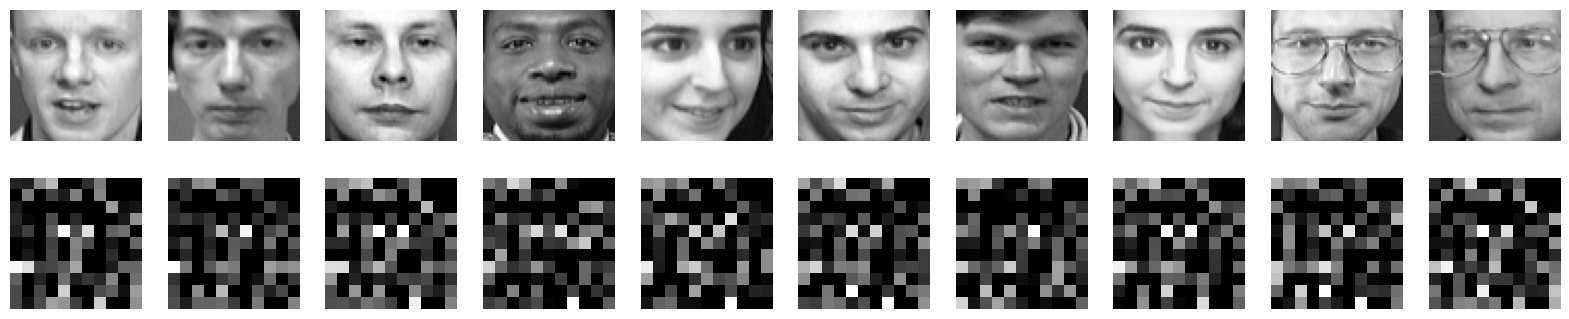

In [38]:
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    ax[1, i].imshow(nmf_net.H[i].cpu().numpy().reshape(11, 11), cmap="gray")
    ax[0, i].imshow(X_val[i].cpu().numpy().reshape(64, 64), cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].axis("off")

# Classification using K Nearest Neighbour

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [40]:
torch.mm(nmf_net.H, nmf_net.W).cpu().detach().numpy().shape, y_train.shape

((80, 4096), (320,))

In [50]:
with torch.no_grad():
    # checking the accuracy of the classifier for different values of k
    for i in [1,2,3,4]:
        nmf_net.eval()
        nmf_net.to("cpu")
        nmf_net(torch.tensor(X_train).float())
        classifier = KNeighborsClassifier(n_neighbors=i)
        classifier.fit(nmf_net.H, y_train)
        nmf_net(torch.tensor(X_val).float())
        y_pred = classifier.predict(nmf_net.H)
        print("Accuracy for k =", i, "is", accuracy_score(y_val, y_pred))
        

C:\Users\Asus\AppData\Local\Temp\ipykernel_27116\3486154286.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nmf_net(torch.tensor(X_val).float())
C:\Users\Asus\AppData\Local\Temp\ipykernel_27116\3486154286.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nmf_net(torch.tensor(X_val).float())


Accuracy for k = 1 is 0.9125
Accuracy for k = 2 is 0.8375
Accuracy for k = 3 is 0.85
Accuracy for k = 4 is 0.8125


C:\Users\Asus\AppData\Local\Temp\ipykernel_27116\3486154286.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nmf_net(torch.tensor(X_val).float())
C:\Users\Asus\AppData\Local\Temp\ipykernel_27116\3486154286.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nmf_net(torch.tensor(X_val).float())
